# EqualWidthDiscretiser + OrdinalEncoder


This is very useful for linear models, because by using discretisation + a monotonic encoding we create monotonic variables, from those that before were not originally. And this tends to hep improve the performance of the model. 

## EqualWidthDiscretiser

The EqualWidthDiscretiser() divides continuous numerical variables into
intervals of the same width, that is, equidistant intervals. Note that the
proportion of observations per interval may vary.

The number of intervals
in which the variable should be divided must be indicated by the user.

<b>Note:</b> Read EqualWidthDiscretiser notebook to know more about this transformer

## OrdinalEncoder
The OrdinalEncoder() will replace the variable labels by digits, from 1 to the number of different labels. 

If we select "arbitrary", then the encoder will assign numbers as the labels appear in the variable (first come first served).

If we select "ordered", the encoder will assign numbers following the mean of the target value for that label. So labels for which the mean of the target is higher will get the number 1, and those where the mean of the target is smallest will get the number n.

<b>Note:</b> Read OrdinalEncoder notebook to know more about this transformer

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.discretisation import EqualWidthDiscretiser
from feature_engine.encoding import OrdinalEncoder
from sklearn.pipeline import Pipeline

plt.rcParams["figure.figsize"] = [15,5]

In [9]:
# Load titanic dataset from OpenML

def load_titanic():
    data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')
    data = data.replace('?', np.nan)
    data['cabin'] = data['cabin'].astype(str).str[0]
    data['pclass'] = data['pclass'].astype('O')
    data['age'] = data['age'].astype('float').fillna(data.age.median())
    data['fare'] = data['fare'].astype('float').fillna(data.fare.median())
    data['embarked'].fillna('C', inplace=True)
    data.drop(labels=['boat', 'body', 'home.dest'], axis=1, inplace=True)
    return data

In [10]:
data = load_titanic()
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B,S
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C,S
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C,S
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C,S
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C,S


In [11]:
# let's separate into training and testing set
X = data.drop(['survived', 'name', 'ticket'], axis=1)
y = data.survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("X_train :" ,X_train.shape)
print("X_test :" ,X_test.shape)

X_train : (916, 8)
X_test : (393, 8)


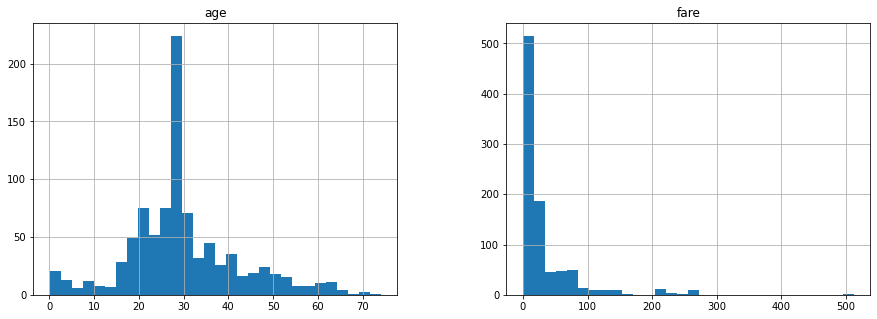

In [12]:
# we will use two continuous variables for transformation
X_train[["age", 'fare']].hist(bins=30)
plt.show()

In [14]:
# pipeline 

transformer = Pipeline(steps=[('EqualWidthDiscretiser', EqualWidthDiscretiser(bins=5,
                                                                                  variables=['age','fare'],
                                                                                  return_object=True)),#returns values as categorical
                              ('OrdinalEncoder',OrdinalEncoder(variables=['age','fare']))
                             ])
transformer.fit(X_train,y_train)

Pipeline(steps=[('EqualWidthDiscretiser',
                 EqualWidthDiscretiser(bins=5, return_object=True,
                                       variables=['age', 'fare'])),
                ('OrdinalEncoder', OrdinalEncoder(variables=['age', 'fare']))])

In [15]:
transformer.named_steps['EqualWidthDiscretiser'].binner_dict_

{'age': [-inf,
  14.933359999999999,
  29.700019999999995,
  44.46667999999999,
  59.23333999999999,
  inf],
 'fare': [-inf, 102.46584, 204.93168, 307.39752, 409.86336, inf]}

In [16]:
transformer.named_steps['OrdinalEncoder'].encoder_dict_

{'age': {4: 0, 1: 1, 2: 2, 3: 3, 0: 4}, 'fare': {0: 0, 2: 1, 1: 2, 4: 3}}

In [17]:
train_t = transformer.transform(X_train)
test_t = transformer.transform(X_test)

test_t.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked
1139,3,male,2,0,0,0,n,S
533,2,female,1,0,1,0,n,S
459,2,male,2,1,0,0,n,S
1150,3,male,1,0,0,0,n,S
393,2,male,1,0,0,0,n,S


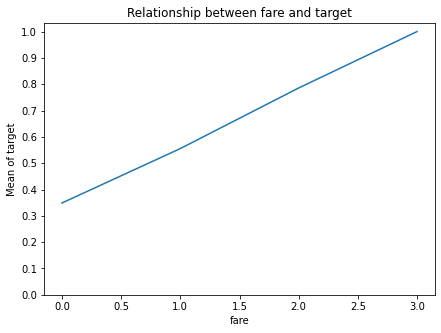

In [18]:
# let's explore the monotonic relationship
plt.figure(figsize=(7,5))
pd.concat([test_t,y_test], axis=1).groupby("fare")["survived"].mean().plot()
#plt.xticks([0,1,2])
plt.yticks(np.arange(0,1.1,0.1))
plt.title("Relationship between fare and target")
plt.xlabel("fare")
plt.ylabel("Mean of target")
plt.show()